In [3]:
import os

for dirname, _, filenames in os.walk('avazu-ctr-prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

avazu-ctr-prediction/test.gz
avazu-ctr-prediction/train.gz
avazu-ctr-prediction/sampleSubmission.gz


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y_true, y_pred, epsilon=1e-8): # epsilon to prevent log(0)
    return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))

def compute_gradients(X, y_true, y_pred):
    m = X.shape[0]
    dw = np.dot(X.T, (y_pred - y_true)) / m
    db = np.mean(y_pred - y_true)
    return dw, db

def predict(X, weights, bias):
    linear_combination = np.dot(X, weights) + bias
    return sigmoid(linear_combination)

def evaluate(X, y_true, weights, bias):
    y_pred = predict(X, weights, bias)
    loss = compute_loss(y_true, y_pred)
    accuracy = np.mean((y_pred >= 0.5) == y_true)
    return loss, accuracy

def train_logistic_regression(X_train, y_train, X_val, y_val, num_epochs, batch_size, learning_rate):
    input_dim = X_train.shape[1]
    weights = np.zeros(input_dim)
    bias = 0.0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Shuffling the training data at the beginning of each epoch
        permutation = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        epoch_loss = 0

        # Iterating over mini-batches
        for i in range(0, X_train.shape[0], batch_size):

            # Extracting the mini-batch
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]

            # Forward pass
            predictions = predict(X_batch, weights, bias)

            # Computing loss
            loss = compute_loss(y_batch, predictions)
            epoch_loss += loss

            # Updating weights and bias
            dw, db = compute_gradients(X_batch, y_batch, predictions)

            weights -= learning_rate * dw
            bias -= learning_rate * db

        # Average loss for the epoch
        epoch_loss /= (X_train.shape[0] // batch_size) # Divided By Number of Batches
        train_losses.append(epoch_loss)

        # Computing Validation loss
        val_loss, val_accuracy = evaluate(X_val, y_val, weights, bias)
        val_losses.append(val_loss)

        # Printing loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    return weights, bias, train_losses, val_losses

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Loading and preprocessing data
train_df = pd.read_csv('avazu-ctr-prediction/train.gz', compression='gzip', nrows=1000000)
shuffled_df = train_df.sample(frac=1).drop(['device_ip'], axis=1)

# Encoding string columns
string_columns = shuffled_df.select_dtypes(include=['object']).columns
encodings = {}
for col in string_columns:
    codes, uniques = pd.factorize(shuffled_df[col])
    shuffled_df[col] = codes
    encodings[col] = {'uniques': uniques}

# Preparing features and target
X = shuffled_df.drop(['click', 'id'], axis=1)
y = shuffled_df['click']

# Splitting the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=77)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=77)

# Normalizing the data using Min-Max scaling
mmscaler = MinMaxScaler()
X_train_np = mmscaler.fit_transform(X_train)
X_val_np = mmscaler.transform(X_val)
X_test_np = mmscaler.transform(X_test)

# Converting to numpy arrays
y_train_np = y_train.values
y_val_np = y_val.values
y_test_np = y_test.values

# Setting hyperparameters
num_epochs = 200
batch_size = 256
learning_rate = 0.01

# Training the model
weights, bias, train_losses, val_losses = train_logistic_regression(X_train_np, y_train_np, X_val_np, y_val_np,
    num_epochs, batch_size, learning_rate)

Epoch [10/200], Train Loss: 0.4271, Val Loss: 0.4278, Val Accuracy: 0.8392
Epoch [20/200], Train Loss: 0.4253, Val Loss: 0.4261, Val Accuracy: 0.8392
Epoch [30/200], Train Loss: 0.4242, Val Loss: 0.4251, Val Accuracy: 0.8392
Epoch [40/200], Train Loss: 0.4234, Val Loss: 0.4243, Val Accuracy: 0.8392
Epoch [50/200], Train Loss: 0.4227, Val Loss: 0.4237, Val Accuracy: 0.8392
Epoch [60/200], Train Loss: 0.4222, Val Loss: 0.4231, Val Accuracy: 0.8392
Epoch [70/200], Train Loss: 0.4217, Val Loss: 0.4226, Val Accuracy: 0.8392
Epoch [80/200], Train Loss: 0.4213, Val Loss: 0.4222, Val Accuracy: 0.8392
Epoch [90/200], Train Loss: 0.4209, Val Loss: 0.4219, Val Accuracy: 0.8392
Epoch [100/200], Train Loss: 0.4206, Val Loss: 0.4215, Val Accuracy: 0.8392
Epoch [110/200], Train Loss: 0.4203, Val Loss: 0.4212, Val Accuracy: 0.8392
Epoch [120/200], Train Loss: 0.4200, Val Loss: 0.4210, Val Accuracy: 0.8392
Epoch [130/200], Train Loss: 0.4198, Val Loss: 0.4207, Val Accuracy: 0.8392
Epoch [140/200], Trai

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def predict_probability(X, weights, bias):
    return sigmoid(np.dot(X, weights) + bias)

def compute_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)
    return precision, recall, average_precision

def plot_precision_recall_curve(precision, recall):
    plt.figure(figsize=(10, 6))
    plt.step(recall, precision, color='b', where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')

    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve')
    plt.show()

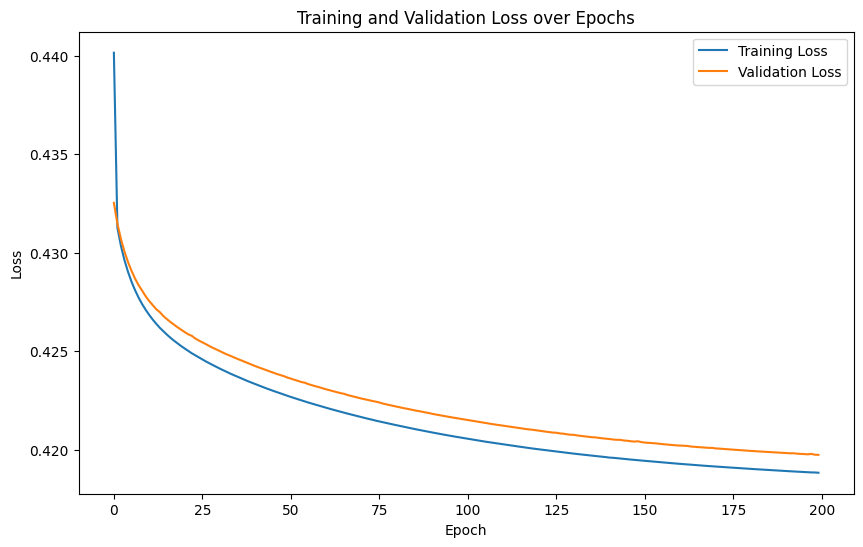

Test Loss: 0.4179, Test Accuracy: 0.8403


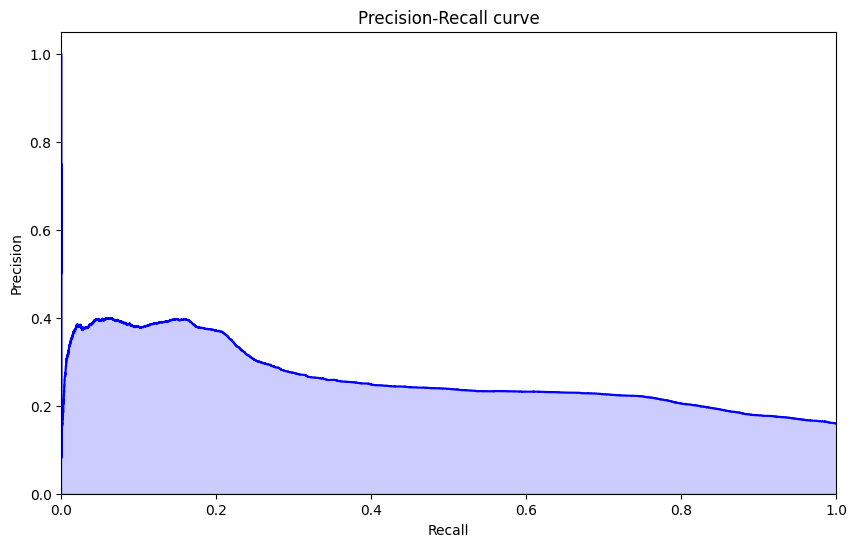

Average Precision: 0.26


In [10]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Evaluating the model on the test set
test_loss, test_accuracy = evaluate(X_test_np, y_test_np, weights, bias)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Computing and plotting precision-recall curve
y_scores = predict_probability(X_test_np, weights, bias)
precision, recall, average_precision = compute_precision_recall_curve(y_test_np, y_scores)
plot_precision_recall_curve(precision, recall)
print(f"Average Precision: {average_precision:0.2f}")

The Precision-Recall curve shows the trade-off between precision ("Of all instances the model labeled as positive, how many actually were positive?") and recall ("Of all actual positive instances, how many did the model correctly identify?") at various thresholds.

The curve slopes downward from left to right representing the trade-off that as recall increases (by lowering the classification threshold), precision tends to decrease. At the left side of the curve (low recall, higher precision), the model is being very selective. It's making fewer positive predictions, but those it makes are more likely to be correct, achieving a max precision of about 0.45. As we move right (higher recall, lower precision), the model is being less selective, with precision falling to around 0.2. It's correctly identifying more of the actual positive cases, but at the cost of making more false positive predictions.